In [102]:
from pyspark.sql import SparkSession

In [103]:
spark = SparkSession.builder.appName('Test').getOrCreate()

In [104]:
spark

In [105]:
data1=spark.read.option('header','true').csv('shopping_trends.csv',inferSchema=True)

In [106]:
data1.printSchema()

root
 |-- Customer ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Item Purchased: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Purchase Amount (USD): integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Review Rating: double (nullable = true)
 |-- Subscription Status: string (nullable = true)
 |-- Payment Method: string (nullable = true)
 |-- Shipping Type: string (nullable = true)
 |-- Discount Applied: string (nullable = true)
 |-- Promo Code Used: string (nullable = true)
 |-- Previous Purchases: integer (nullable = true)
 |-- Preferred Payment Method: string (nullable = true)
 |-- Frequency of Purchases: string (nullable = true)



In [107]:
data1 = data1.drop('Customer ID')
data1.show(5)

+---+------+--------------+--------+---------------------+-------------+----+---------+------+-------------+-------------------+--------------+-------------+----------------+---------------+------------------+------------------------+----------------------+
|Age|Gender|Item Purchased|Category|Purchase Amount (USD)|     Location|Size|    Color|Season|Review Rating|Subscription Status|Payment Method|Shipping Type|Discount Applied|Promo Code Used|Previous Purchases|Preferred Payment Method|Frequency of Purchases|
+---+------+--------------+--------+---------------------+-------------+----+---------+------+-------------+-------------------+--------------+-------------+----------------+---------------+------------------+------------------------+----------------------+
| 55|  Male|        Blouse|Clothing|                   53|     Kentucky|   L|     Gray|Winter|          3.1|                Yes|   Credit Card|      Express|             Yes|            Yes|                14|                 

In [108]:
from pyspark.sql.functions import when, count, col

data1.select([count(when(col(c).isNull(), c)).alias(c) for c in data1.columns]).show()

+---+------+--------------+--------+---------------------+--------+----+-----+------+-------------+-------------------+--------------+-------------+----------------+---------------+------------------+------------------------+----------------------+
|Age|Gender|Item Purchased|Category|Purchase Amount (USD)|Location|Size|Color|Season|Review Rating|Subscription Status|Payment Method|Shipping Type|Discount Applied|Promo Code Used|Previous Purchases|Preferred Payment Method|Frequency of Purchases|
+---+------+--------------+--------+---------------------+--------+----+-----+------+-------------+-------------------+--------------+-------------+----------------+---------------+------------------+------------------------+----------------------+
|  0|     0|             0|       0|                    0|       0|   0|    0|     0|            0|                  0|             0|            0|               0|              0|                 0|                       0|                     0|
+---

In [109]:
from pyspark.sql.types import StringType
categorical_cols = [field.name for field in data1.schema.fields if isinstance(field.dataType, StringType)]
numerical_cols = [field.name for field in data1.schema.fields if not isinstance(field.dataType, StringType)]

print("\nCategorical Columns:")
print(categorical_cols)

print("\nNumerical Columns:")
print(numerical_cols)


Categorical Columns:
['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season', 'Subscription Status', 'Payment Method', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Preferred Payment Method', 'Frequency of Purchases']

Numerical Columns:
['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']


In [110]:
print("\nSummary Statistics for Numerical Columns:")
summary = data1.select(numerical_cols).describe()
summary.show()


Summary Statistics for Numerical Columns:
+-------+-----------------+---------------------+------------------+------------------+
|summary|              Age|Purchase Amount (USD)|     Review Rating|Previous Purchases|
+-------+-----------------+---------------------+------------------+------------------+
|  count|             3900|                 3900|              3900|              3900|
|   mean|44.06846153846154|    59.76435897435898| 3.749948717948712| 25.35153846153846|
| stddev|15.20758912716237|   23.685392250875328|0.7162228139312412|14.447125170462305|
|    min|               18|                   20|               2.5|                 1|
|    max|               70|                  100|               5.0|                50|
+-------+-----------------+---------------------+------------------+------------------+



In [111]:
from pyspark.sql.functions import format_number

print("\nSummary Statistics for Numerical Columns:")
for col_name in summary.columns[1:]: # Skips 'summary' column.
    summary = summary.withColumn(col_name, format_number(col(col_name).cast("float"), 2))

summary.show()


Summary Statistics for Numerical Columns:
+-------+--------+---------------------+-------------+------------------+
|summary|     Age|Purchase Amount (USD)|Review Rating|Previous Purchases|
+-------+--------+---------------------+-------------+------------------+
|  count|3,900.00|             3,900.00|     3,900.00|          3,900.00|
|   mean|   44.07|                59.76|         3.75|             25.35|
| stddev|   15.21|                23.69|         0.72|             14.45|
|    min|   18.00|                20.00|         2.50|              1.00|
|    max|   70.00|               100.00|         5.00|             50.00|
+-------+--------+---------------------+-------------+------------------+



In [112]:
print("\nUnique Values in Categorical Columns:")
for col_name in categorical_cols:
    unique_count = data1.select(col_name).distinct().count()
    print(f"{col_name}: {unique_count} unique values")


Unique Values in Categorical Columns:
Gender: 2 unique values
Item Purchased: 25 unique values
Category: 4 unique values
Location: 50 unique values
Size: 4 unique values
Color: 25 unique values
Season: 4 unique values
Subscription Status: 2 unique values
Payment Method: 6 unique values
Shipping Type: 6 unique values
Discount Applied: 2 unique values
Promo Code Used: 2 unique values
Preferred Payment Method: 6 unique values
Frequency of Purchases: 7 unique values


In [113]:
from pyspark.sql.functions import mean, col
for col_name in categorical_cols:
    print(f"Analyzing {col_name}:")
    data2.groupBy(col_name).agg(mean('Purchase Amount (USD)').alias('Avg_Purchase')).show()

#Average purchase amount ~60 USD across the board.

Analyzing Gender:
+------+------------------+
|Gender|      Avg_Purchase|
+------+------------------+
|Female|60.249198717948715|
|  Male|59.536199095022624|
+------+------------------+

Analyzing Item Purchased:
+--------------+------------------+
|Item Purchased|      Avg_Purchase|
+--------------+------------------+
|       T-shirt| 62.91156462585034|
|        Jacket| 56.74233128834356|
|      Sneakers| 59.55172413793103|
|          Belt| 59.84472049689441|
|         Dress| 62.16867469879518|
|       Sweater| 57.69512195121951|
|           Hat| 60.87662337662338|
|          Coat|57.608695652173914|
|    Sunglasses| 59.93167701863354|
|         Pants|59.005847953216374|
|        Hoodie| 58.05960264900662|
|       Handbag|57.888888888888886|
|        Gloves|             60.55|
|      Backpack| 60.39160839160839|
|         Shirt| 61.13609467455621|
|         Shoes|              61.6|
|        Blouse| 60.87719298245614|
|       Jewelry|58.538011695906434|
|         Boots|            62.

In [114]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

#StringIndexer converts string categories to numerical.
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_Index", handleInvalid='skip')
    for col in categorical_cols
]

#OneHotEncodeer to create sparse vectors for each category.
encoders = [
    OneHotEncoder(inputCol=f"{col}_Index", outputCol=f"{col}_Encoded")
    for col in categorical_cols
]

pipeline = Pipeline(stages = indexers + encoders)

data2 = pipeline.fit(data1).transform(data1)

data2.select(*[f"{col}_Encoded" for col in categorical_cols]).show(5)

+--------------+----------------------+----------------+----------------+-------------+---------------+--------------+---------------------------+----------------------+---------------------+------------------------+-----------------------+--------------------------------+------------------------------+
|Gender_Encoded|Item Purchased_Encoded|Category_Encoded|Location_Encoded| Size_Encoded|  Color_Encoded|Season_Encoded|Subscription Status_Encoded|Payment Method_Encoded|Shipping Type_Encoded|Discount Applied_Encoded|Promo Code Used_Encoded|Preferred Payment Method_Encoded|Frequency of Purchases_Encoded|
+--------------+----------------------+----------------+----------------+-------------+---------------+--------------+---------------------------+----------------------+---------------------+------------------------+-----------------------+--------------------------------+------------------------------+
| (1,[0],[1.0])|        (24,[0],[1.0])|   (3,[0],[1.0])| (49,[21],[1.0])|(3,[1],[1.0]

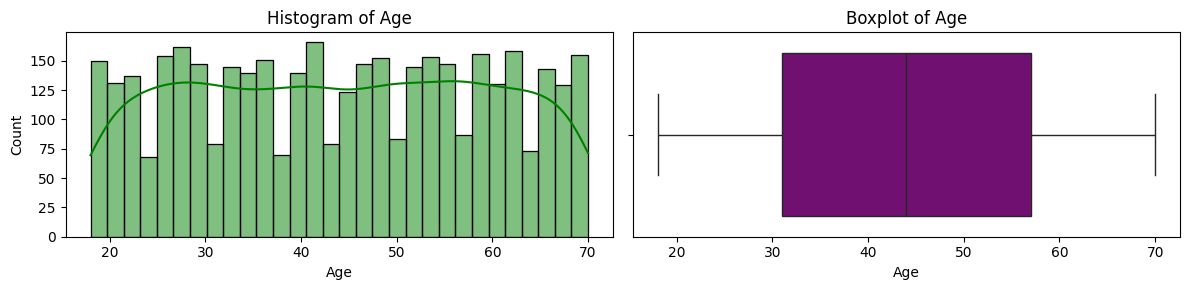

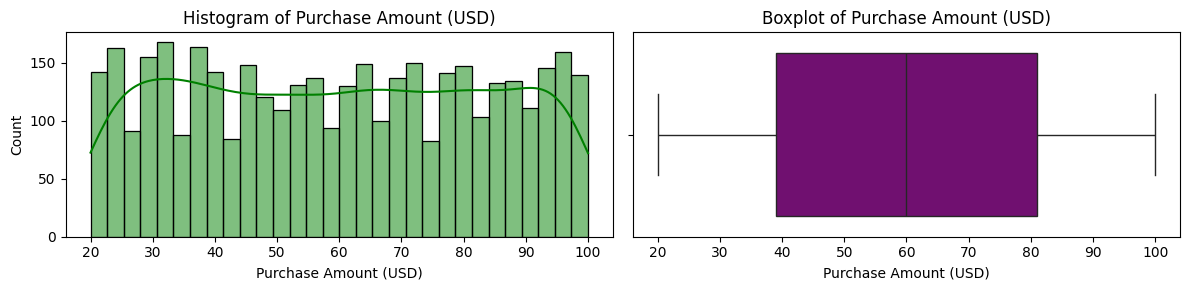

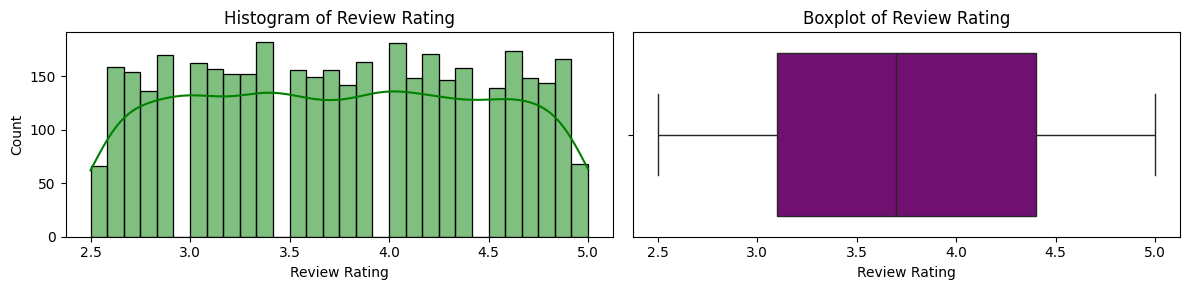

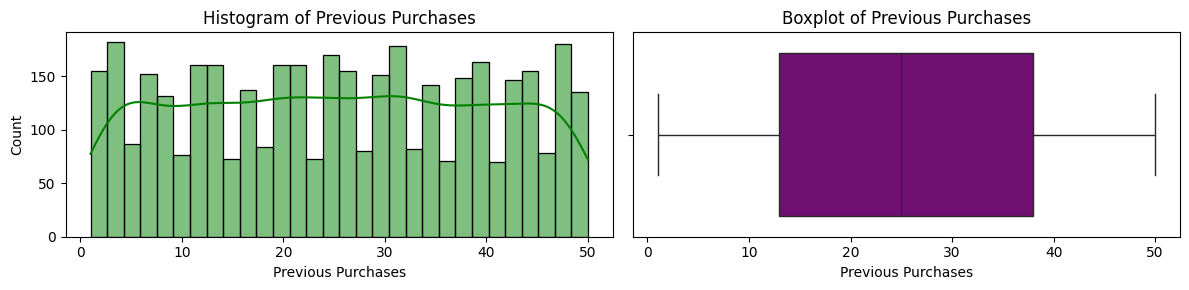

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

data3 = data2.select(numerical_cols).toPandas()

for col in numerical_cols:
    plt.figure(figsize=(12,3))
    plt.subplot(1, 2, 1)
    sns.histplot(data3[col], kde=True, bins=30, color='green')
    plt.title(f"Histogram of {col}")


    plt.subplot(1, 2, 2)
    sns.boxplot(x=data3[col], color='purple')
    plt.title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

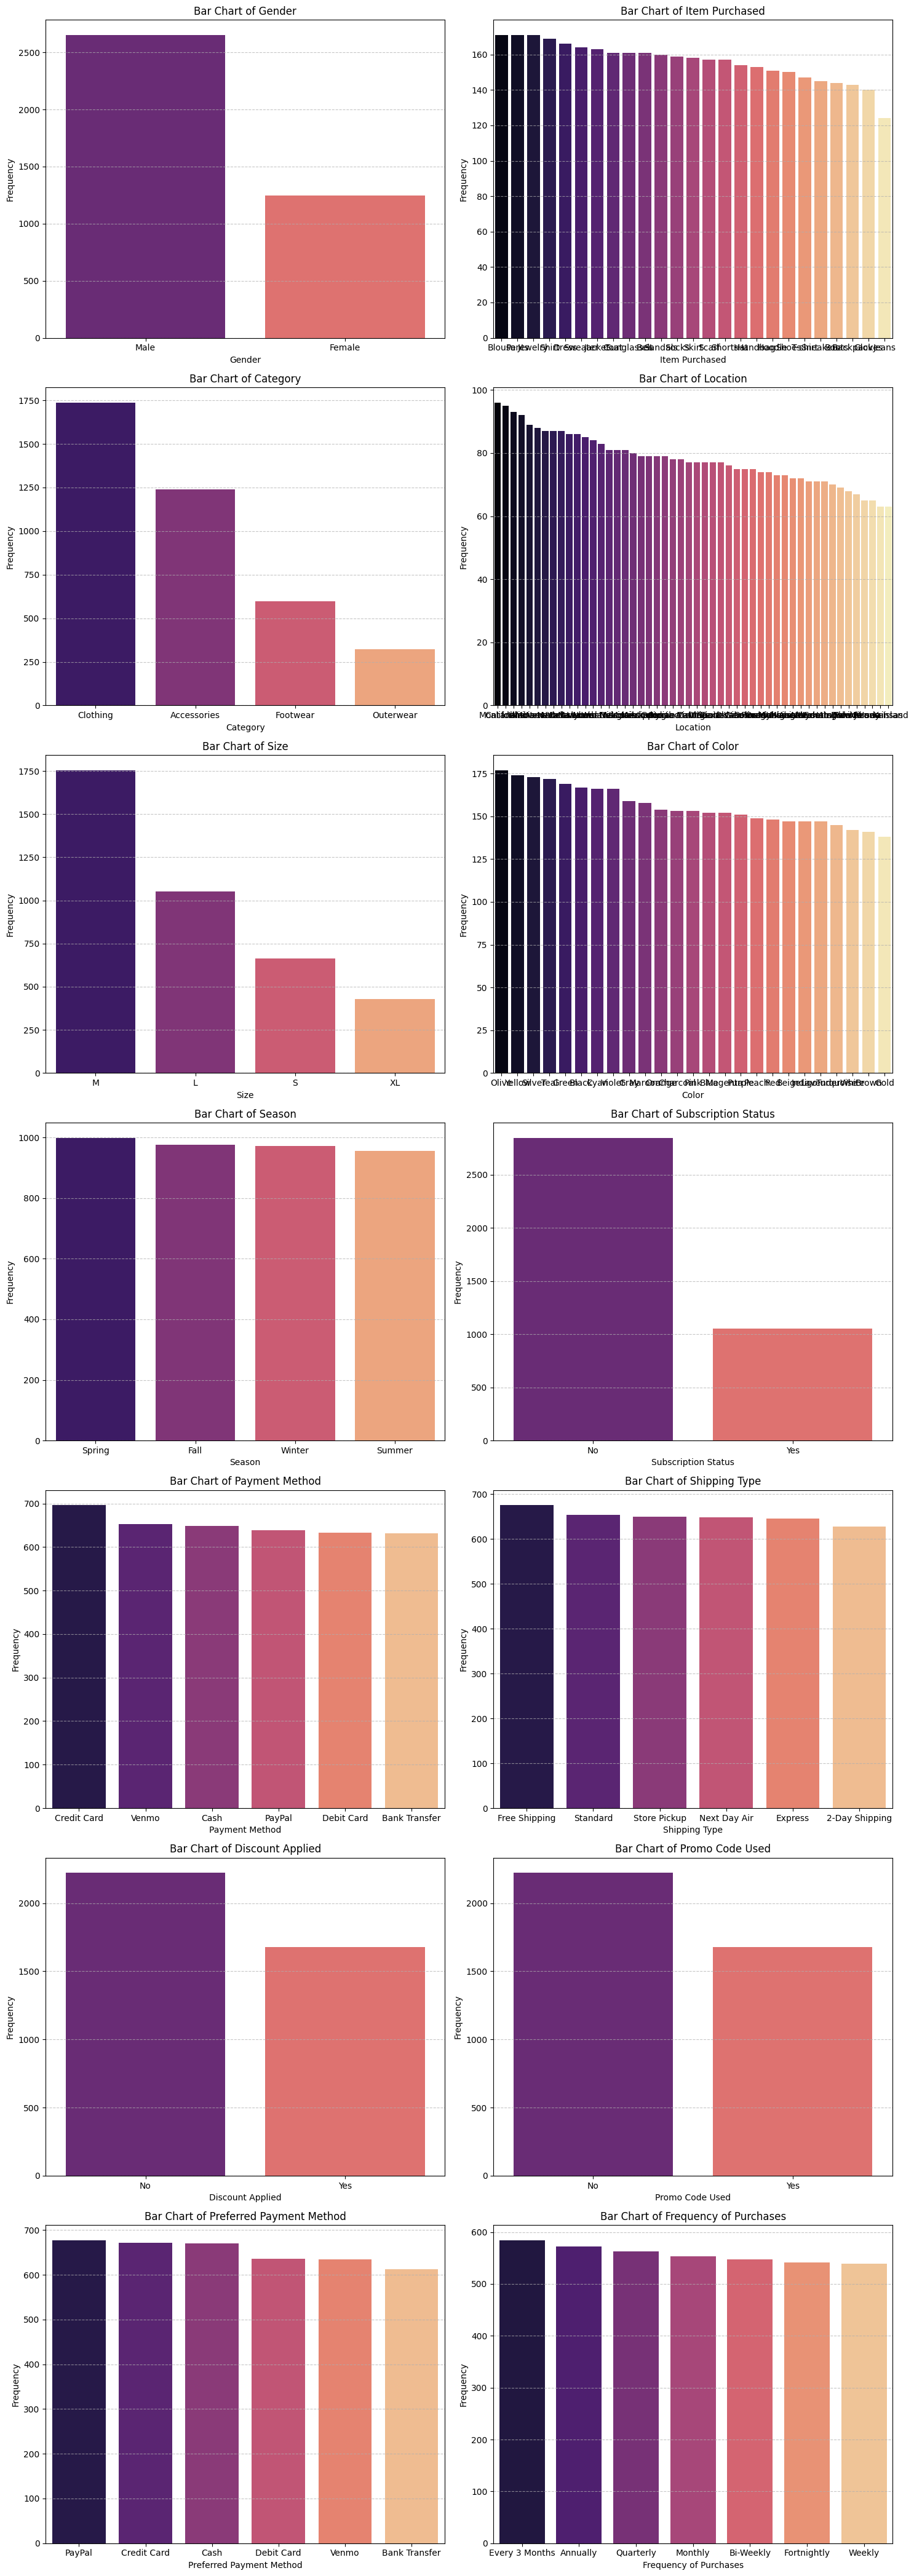

In [116]:
categorical_cols = [field.name for field in data2.schema.fields if isinstance(field.dataType, StringType)]
numerical_cols = [field.name for field in data2.schema.fields if not isinstance(field.dataType, StringType)]


data3 = data2.select(categorical_cols).toPandas()

rows = 2
n_rows = (len(categorical_cols) + 1) // rows

fig, axes = plt.subplots(n_rows,rows, figsize=(15, 6 * n_rows))
axes = axes.flatten() #Flatten to 2D array.

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]
    value_counts=data3[col].value_counts()

    sns.barplot(
        x=value_counts.index,
        y=value_counts.values,
        palette='magma',
        hue=value_counts.index,
        legend=False,
        ax=ax
    )

    ax.set_title(f"Bar Chart of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

for idx in range(len(categorical_cols),len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [117]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

assembler = VectorAssembler(inputCols=numerical_cols, outputCol='Numerical_Vector')
data2v = assembler.transform(data2)
scaler = MinMaxScaler(inputCol='Numerical_Vector', outputCol='Scaled_nv')
scaler_model = scaler.fit(data2v)
data_scaled = scaler_model.transform(data2v)
data_scaled.select('Scaled_nv').show(5, truncate=False)

data4 = data_scaled

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Scaled_nv                                                                                                                                                                                                                                                                                                                         |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(149,[0,1,2,3,7,8,9,10,1

In [118]:
indexed_cols = [f"{col}_Index" for col in categorical_cols]
assembler = VectorAssembler(inputCols=indexed_cols, outputCol='Features_Vector')
data2 = assembler.transform(data2)

In [119]:
from pyspark.ml.stat import ChiSquareTest

chi_square_result = ChiSquareTest.test(data2, "Features_Vector", "Purchase Amount (USD)").head()

print("Chi-Square Test Results:")
for i, col_name in enumerate(indexed_cols):
    print(f"{col_name}: p-value = {chi_square_result.pValues[i]}")

#Season low p-value at 0.024.

Chi-Square Test Results:
Gender_Index: p-value = 0.9348255864248678
Item Purchased_Index: p-value = 0.9988865399360337
Category_Index: p-value = 0.9772817569398443
Location_Index: p-value = 0.5194680259879112
Size_Index: p-value = 0.5883888472528729
Color_Index: p-value = 0.2478663244954692
Season_Index: p-value = 0.02439648091599833
Subscription Status_Index: p-value = 0.06963759251881785
Payment Method_Index: p-value = 0.7557268758053121
Shipping Type_Index: p-value = 0.6334247587347979
Discount Applied_Index: p-value = 0.4314348853783141
Promo Code Used_Index: p-value = 0.4314348853783141
Preferred Payment Method_Index: p-value = 0.47587339614832547
Frequency of Purchases_Index: p-value = 0.08102425119596424


In [120]:
train_data,  test_data, val_data = data4.randomSplit([0.7, 0.2, 0.1], seed = 99)

In [121]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='Scaled_nv', labelCol='Purchase Amount (USD)', maxIter=100)
lr_model = lr.fit(train_data)

In [122]:
test_results = lr_model.evaluate(test_data)

r2 = test_results.r2
rmse = test_results.rootMeanSquaredError
n = test_data.count()
p = len(numerical_cols) + len(categorical_cols)

adjusted_r2 = 1 - ((1 - r2) * (n-1) / (n - p - 1))

print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"Adjusted R2: {adjusted_r2}")
#Metrics are great but potentially the model is overfitting.

R2: 0.999999999937234
RMSE: 0.00018464308965346037
Adjusted R2: 0.9999999999333843


In [123]:
val_predictions = lr_model.transform(val_data)
val_predictions.select('prediction', 'Purchase Amount (USD)').show(15)
#Model performs exceptionally well.

+------------------+---------------------+
|        prediction|Purchase Amount (USD)|
+------------------+---------------------+
| 32.00048230082369|                   32|
| 85.99978931484898|                   86|
| 62.00001297966733|                   62|
| 55.99984995224467|                   56|
| 77.00025166923682|                   77|
| 32.99969469383051|                   33|
| 46.99983403118968|                   47|
| 63.00009632209965|                   63|
| 32.00009446636233|                   32|
|  68.9998219762112|                   69|
|25.000384693339164|                   25|
| 76.00002773415672|                   76|
|37.999696394665975|                   38|
| 72.99980794745653|                   73|
| 71.99965971468733|                   72|
+------------------+---------------------+
only showing top 15 rows



In [126]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(featuresCol='Scaled_nv', labelCol='Purchase Amount (USD)', numTrees=100, maxDepth=10)
rf_model= rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol='Purchase Amount (USD)', predictionCol='prediction')

r2_rf = evaluator.setMetricName("r2").evaluate(rf_predictions)
rmse_rf = evaluator.setMetricName("rmse").evaluate(rf_predictions)

n_rf = test_data.count()
p_rf = len(numerical_cols) + len(categorical_cols)
adjusted_r2_rf = 1 - ((1 - r2_rf) * (n_rf - 1) / (n_rf - p_rf - 1))

print(f"Random Forest Regressor R2: {r2_rf}")
print(f"Random Forest Regressor RMSE: {rmse_rf}")
print(f"Random Forest Regressor Adjusted R2: {adjusted_r2_rf}")

Random Forest Regressor R2: 0.9886059243679146
Random Forest Regressor RMSE: 2.487769865747471
Random Forest Regressor Adjusted R2: 0.9879070877291467


In [127]:
val_predictions = rf_model.transform(val_data)
val_predictions.select('prediction', 'Purchase Amount (USD)').show(15)
#Model shows worse performance than Linear Regression, relationships in the data are likely linear.

+------------------+---------------------+
|        prediction|Purchase Amount (USD)|
+------------------+---------------------+
| 33.78011586232753|                   32|
| 86.47248282027273|                   86|
| 63.82869391133825|                   62|
|52.394100439757125|                   56|
| 75.34396062804124|                   77|
| 32.60369887139871|                   33|
| 47.97682759504298|                   47|
| 65.63578015392862|                   63|
| 33.83218854464356|                   32|
| 69.32888151942231|                   69|
|30.848059512176818|                   25|
| 74.93933397710252|                   76|
| 38.02734492836743|                   38|
| 73.13820714253904|                   73|
| 72.32917834913553|                   72|
+------------------+---------------------+
only showing top 15 rows

